In [1]:
import sys
import SimpleITK as sitk
from pathlib import Path
sys.path.append('../utils/')
import nilearn
from nilearn.plotting import view_img, glass_brain, plot_anat, plot_epi

from dataset import parse_raw_images, plot_random_layers, get_segmented_lungs, get_segmented_lungs_3d
from metrics import target_registration_error
import pandas as pd

## Getting the data ready

In [2]:
out_path=Path('../result_test_data/')
data_path=Path('../test_data/')

In [3]:
data = parse_raw_images(data_path,out_path)
data
data.to_csv(out_path/'dir_lab_test_copd.csv')

Size: (94, 256, 256)


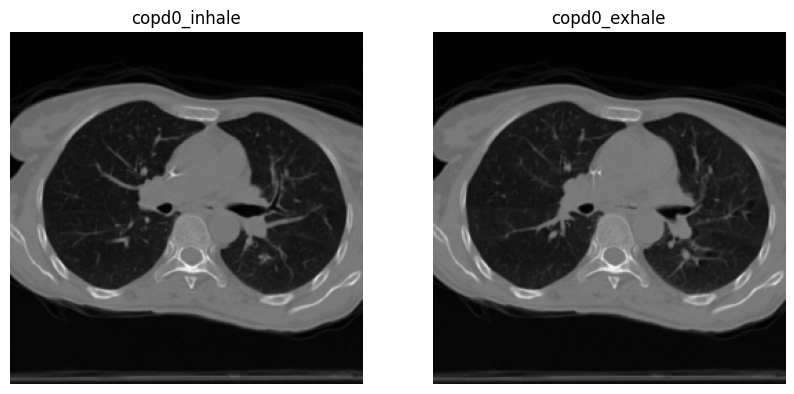

Size: (131, 512, 512)


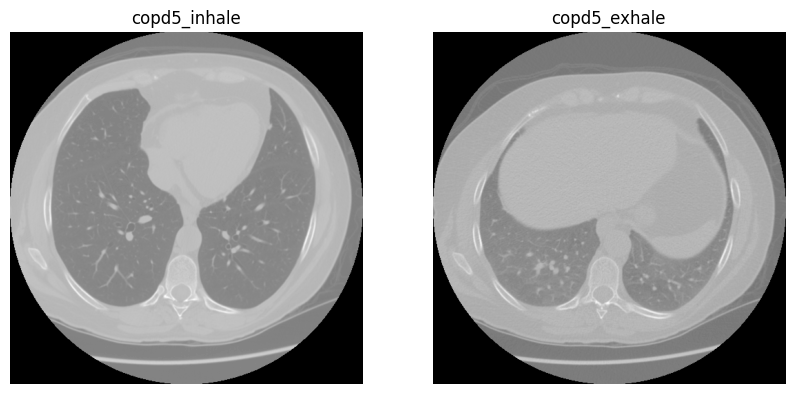

Size: (119, 512, 512)


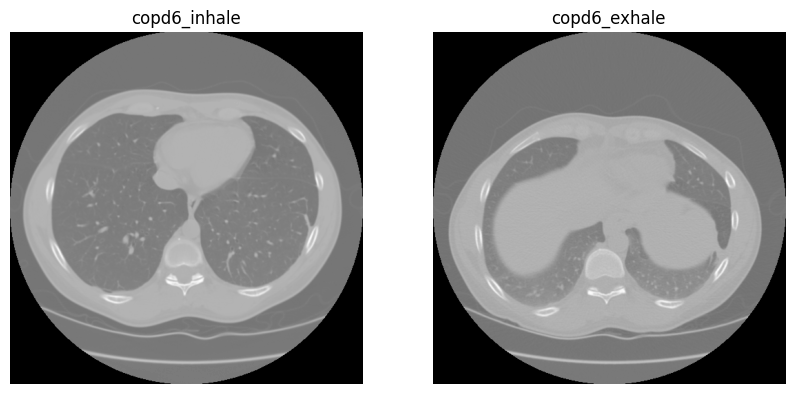

In [6]:
for i in range(len(data)):
    sample = data.iloc[i]
    plot_random_layers(sample['i_img_path'], sample['e_img_path'], sample['case'])

Size: (94, 256, 256)


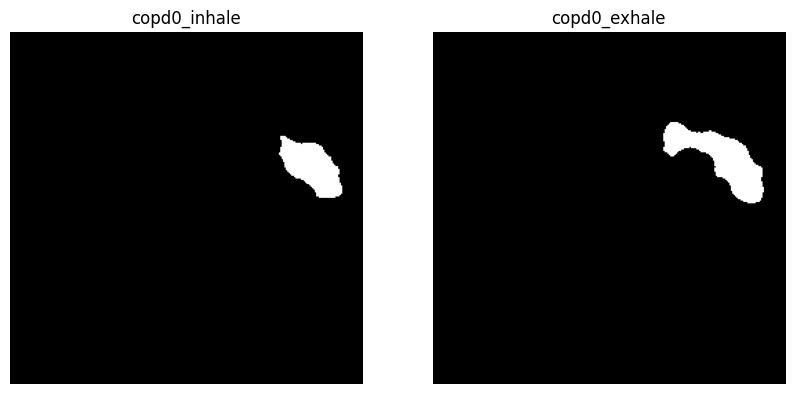

Size: (131, 512, 512)


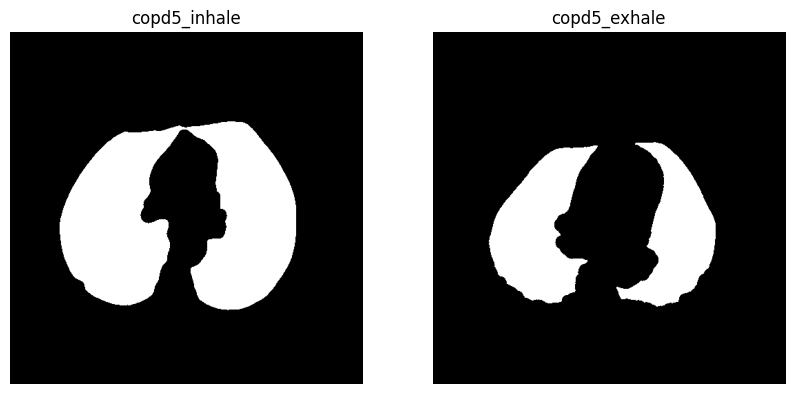

Size: (119, 512, 512)


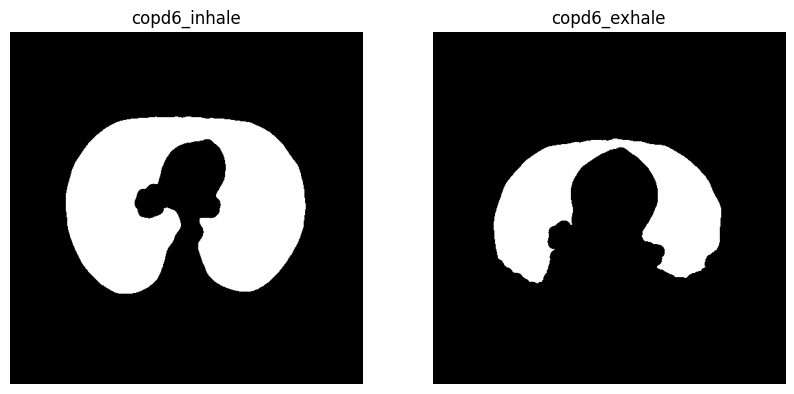

In [12]:
for i in range(len(data)):
    sample = data.iloc[i]
    plot_random_layers(sample['i_mask_path'], sample['e_mask_path'], sample['case'])

In [13]:
from pathlib import Path
thispath = Path('__file__').resolve()
base_path = thispath.parent.parent
import sys; sys.path.insert(0, str(base_path))
import json
sys.path.append('../utils/')
import time

In [14]:
import SimpleITK as sitk
import pandas as pd
from tqdm.auto import tqdm
import time
import numpy as np
from metrics import get_landmarks_array_from_txt_file, target_registration_error
from elastic_helpers import elastix_wrapper, modify_field_parameter_map,transformix_wrapper

In [15]:
base_path = Path().resolve().parent
params_path = base_path / 'parameters'
output_path = base_path /'elastix'
results_path = base_path / 'experiments' / 'elastik' / 'results.json'

In [18]:
def registration(dataset,param_maps_to_use,experiment_name,masks=False):
    results = {}

    for i in tqdm(range(len(dataset))):
        sample = dataset.iloc[i]
        sample_data = sample['case']
        sample_mean = sample['disp_mean']
        sample_std = sample['disp_std']

        pm = param_maps_to_use[-1]
        data_path = base_path / 'result_test_data' / sample_data
        output_pm_path = output_path / pm.rstrip('.txt') / experiment_name
        output_pm_path.mkdir(exist_ok=True, parents=True)

        parameters_filename = params_path
        result_path = output_path / sample['case'] / experiment_name
        result_path.mkdir(exist_ok=True, parents=True)
        
        param_maps_to_use_ = [str(params_path / p) for p in param_maps_to_use]
        name = sample['case']
        i_temp_path = data_path / f'{sample_data}_iBHCT.nii.gz'
        e_temp_path = data_path / f'{sample_data}_eBHCT.nii.gz'
        i_lungs_mask_temp_path = data_path / f'{sample_data}_iBHCT_masks.nii.gz'
        e_lungs_mask_temp_path = data_path / f'{sample_data}_eBHCT_masks.nii.gz'
        
        print('Registration of image...')
        start = time.time()
        
        if masks is False:
            transform_map_path = elastix_wrapper(
                i_temp_path, e_temp_path, result_path.parent, param_maps_to_use_,
                verbose=False, keep_just_useful_files=False
            )
        else:
            transform_map_path = elastix_wrapper(
                i_temp_path, e_temp_path, result_path.parent, param_maps_to_use_,
                i_lungs_mask_temp_path, e_lungs_mask_temp_path, verbose=False,
                keep_just_useful_files=False
            )
        
        
        reg_time = time.time() - start
        name = f'{sample_data}_300_iBH_xyz_r1.txt'
        lm_points_filepath = data_path / name
        name_result = f'{sample_data}_300_iBH_xyz_r1_transformt.txt'
        
        field_value_pairs = [
            ('ResultImageFormat', 'nii.gz'),
            ('ResultImagePixelType', "float"),
            ('FinalBSplineInterpolationorder', '0')
        ]

        modify_field_parameter_map(field_value_pairs, transform_map_path)
        
        # Transform landmarks
        print('Transforming points...')
        lm_out_filepath = result_path.parent / f'r_{sample_data}'
        transformix_wrapper(
            lm_points_filepath, lm_out_filepath, transform_map_path,
            points=True)
               
        landmarks = get_landmarks_array_from_txt_file(lm_out_filepath / name)
        df = pd.DataFrame(landmarks)
        df.to_csv(str(lm_out_filepath / name), sep='\t', index=False)

        '''
        e_landmark_pts = pd.read_csv(sample['e_landmark_pts'], header=None, index_col=None).values
        m, s = target_registration_error(landmarks, e_landmark_pts, [sample['space_x'],sample['space_y'],sample['space_z']])
        print(f'{"-"*10} {sample_data} {"-"*10}')
        print(f'Provided displacement: {sample_mean} | {sample_std} ')
        print(f'Computed displacement: {m} | {s}')
        '''
        results[sample['case']] = {
            'time': reg_time
        }
    
    return results

In [19]:
experiment_results = {}

In [22]:
experiment_name = 'best_untilnow'
param_maps_to_use = [
        'best_untilnow.txt'
]
experiment_results[experiment_name] = \
    registration(data,param_maps_to_use,experiment_name,masks=True)
with open(results_path, 'w') as json_file:
    json.dump(experiment_results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/3 [00:00<?, ?it/s]

Registration of image...
Transforming points...
Registration of image...
Transforming points...
Registration of image...
Transforming points...
